In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

sys.path.append(os.path.join(Path().resolve(), 'DigiLeTs/scripts'))

In [116]:
import cv2
import copy

# class DrawingEnv_Digit:
#     def __init__(self, params: dict) -> None:
#         self.size = params["size"]
#         self.line_width = params["line_width"]
#         self.initial_position = params["initial_position"]
#         self.max_step = params["max_step"]
#         self.img = None
#         self.prev_position = self.initial_position
#         self._itr = 0
        
#     def init(self, initial_position=None):
#         self.img = np.zeros((self.size, self.size, 3))
#         self._itr = 0
#         if initial_position == None:
#             self.prev_position = self.initial_position
#         else:
#             self.prev_position = initial_position
#         observation = dict(image=self.img,
#                            mask=self.img,
#                            position=self.prev_position)
#         return observation
        
#     def step(self, position, draw=True):
#         if draw:
#             _img = cv2.line(img=self.img,
#                             pt1=(int(self.prev_position[0]*self.size), int(self.prev_position[1]*self.size)),
#                             pt2=(int(position[0]*self.size), int(position[1]*self.size)),
#                             color=(0, 255, 0),
#                             thickness=self.line_width,
#                             lineType=cv2.LINE_AA,
#                             )
#         else:
#             _img = self.img
#         self.img = copy.deepcopy(_img)
#         self.prev_position = position
#         observation = dict(image=self.img,
#                            mask=self.img,
#                            position=position,
#                            )
#         reward = 0
#         done = False
#         info = dict()
#         self._itr += 1
#         if self._itr >= self.max_step:
#             done = True
#         return observation, reward, done, info

class DrawingEnv_Digit:
    def __init__(self, params: dict) -> None:
        self.size = params["size"]
        self.line_width = params["line_width"]
        self.initial_position = params["initial_position"]
        self.max_step = params["max_step"]
        self.mask = None
        self.prev_position = self.initial_position
        self._itr = 0
    
    def get_image(self, mask):
        image = np.zeros((self.size, self.size, 3), dtype=np.uint8)
        image[:,:,1] = mask * 255
        return image
    
    def init(self, initial_position=None):
        self.mask = np.zeros((self.size, self.size), dtype=np.uint8)
        image = self.get_image(self.mask)
        self._itr = 0
        if initial_position == None:
            self.prev_position = self.initial_position
        else:
            self.prev_position = initial_position
        observation = dict(image=image,
                           mask=self.mask,
                           position=self.prev_position)
        return observation
        
    def step(self, position, draw=True):
        if draw:
            _mask = cv2.line(img=self.mask,
                            pt1=(int(self.prev_position[0]*self.size), int(self.prev_position[1]*self.size)),
                            pt2=(int(position[0]*self.size), int(position[1]*self.size)),
                            color=1,
                            thickness=self.line_width,
                            lineType=cv2.LINE_AA,
                            )
        else:
            _mask = self.mask
        self.mask = copy.deepcopy(_mask)
        image = self.get_image(self.mask)
        self.prev_position = position
        observation = dict(image=image,
                           mask=self.mask,
                           position=position,
                           )
        reward = 0
        done = False
        info = dict()
        self._itr += 1
        if self._itr >= self.max_step:
            done = True
        return observation, reward, done, info

class DrawingEnv_Body:
    def __init__(self, params: dict) -> None:
        self.size = params["size"]
        self.initial_position = params["initial_position"]
        self.max_step = params["max_step"]
        self._itr = 0
    
    def get_image(self, pos):
        dx = 0.1
        dy = 0.3

        img_body = np.zeros((self.size, self.size, 3), dtype=np.uint8)
        img_body = cv2.rectangle(img=img_body,
                                pt1=(int(pos[0]*self.size), int(pos[1]*self.size)),
                                pt2=(int((pos[0]+dx)*self.size), int((pos[1]+dy)*self.size)),
                                color=(0, 0, 255),
                                thickness=-1,
                                lineType=cv2.LINE_AA,
                                )
        mask = np.zeros((self.size, self.size), dtype=np.uint8)
        mask = cv2.rectangle(img=mask,
                            pt1=(int(pos[0]*self.size), int(pos[1]*self.size)),
                            pt2=(int((pos[0]+dx)*self.size), int((pos[1]+dy)*self.size)),
                            color=1,
                            thickness=-1,
                            lineType=cv2.LINE_AA,
                            )
        return img_body, mask
    
    def init(self, initial_position=None):
        self._itr = 0
        if initial_position == None:
            initial_position = self.initial_position
        img, mask = self.get_image(initial_position)
        observation = dict(image=img,
                           mask=mask,
                           position=initial_position,
                           )
        return observation
        
    def step(self, position):
        img, mask = self.get_image(position)
        observation = dict(image=img,
                           mask=mask,
                           position=position,
                           )
        reward = 0
        done = False
        info = dict()
        self._itr += 1
        if self._itr >= self.max_step:
            done = True
        return observation, reward, done, info

class DrawingEnv_Moc1:
    def __init__(self, params: dict) -> None:
        self.size = params["size"]
        self.env_digit = DrawingEnv_Digit(params)
        self.env_body = DrawingEnv_Body(params)
        self.obs_residual = dict(image=np.zeros((self.size, self.size, 3)))
    
    def get_mask(self, obs_digit, obs_body):
        mask = np.zeros((self.size, self.size, 3))
        mask[:,:,2] = obs_body["mask"]
        # mask[:,:,1] = np.max(np.concatenate([obs_digit["mask"], 1-obs_body["mask"]], axis=0), axis=0)
        mask[:,:,1] = obs_digit["mask"]-obs_body["mask"]
        # mask[:,:,1] = obs_digit["mask"]
        mask[:,:,0] = np.ones((self.size, self.size)) - mask[:,:,1] - mask[:,:,2]
        
        return mask
    
    def marge_image(self, obs_digit, obs_body, obs_residual, mask):
        image = np.zeros((self.size, self.size, 3))
        image += obs_residual["image"] * np.expand_dims(mask[:,:,0], -1)
        image += obs_digit["image"] * np.expand_dims(mask[:,:,1], -1)
        image += obs_body["image"] * np.expand_dims(mask[:,:,2], -1)
        
        return image
    
    def merge_observation(self, obs_digit, obs_body):
        mask = self.get_mask(obs_digit=obs_digit,
                             obs_body=obs_body,
                             )
        image = self.marge_image(obs_digit=obs_digit,
                                 obs_body=obs_body,
                                 obs_residual=self.obs_residual,
                                 mask=mask,
                                 )
        observation = dict(image=image,
                           image_digit=obs_digit["image"],
                           image_body=obs_body["image"],
                           image_residual=self.obs_residual["image"],
                           mask=mask,
                           position=obs_digit["position"],
                           )
        return observation
    
    def init(self, initial_position=None):
        obs_digit = self.env_digit.init()
        obs_body = self.env_body.init()
        
        observation = self.merge_observation(obs_digit=obs_digit,
                                             obs_body=obs_body)
        return observation
    
    def step(self, position, draw=True):
        obs_digit, _, _, _ = self.env_digit.step(position, draw)
        obs_body, _, _, _ = self.env_body.step(position)
        observation = self.merge_observation(obs_digit=obs_digit,
                                             obs_body=obs_body)
        reward = 0
        done = False
        info = dict()
        return observation, reward, done, info



In [117]:
pos = (0.8, 0.6)

params = dict(size=256,
              line_width=3,
              initial_position=(pos[0],pos[1]),
              max_step=2e2,
              )

env = DrawingEnv_Moc1(params)
observation = env.init()
observation, _, _, _ = env.step(pos)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


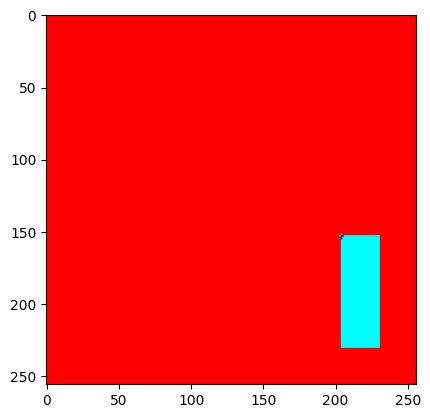

In [118]:
plt.imshow(observation["mask"])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


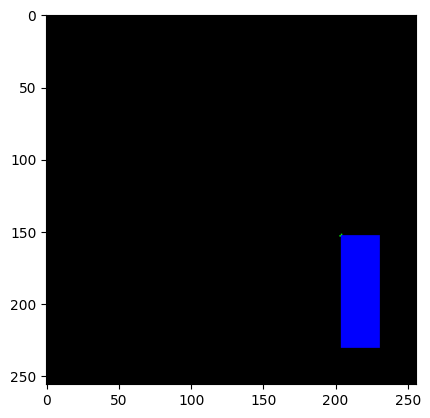

In [119]:
plt.imshow(observation["image"])
plt.show()

In [120]:

pos = (0.8, 0.6)
dx = 0.1
dy = 0.3

size = 256
img_body = np.zeros((size, size))
img_body = cv2.rectangle(img=img_body,
                        pt1=(int(pos[0]*size), int(pos[1]*size)),
                        pt2=(int((pos[0]+dx)*size), int((pos[1]+dy)*size)),
                        color=1,
                        thickness=-1,
                        lineType=cv2.LINE_AA,
                        )
# position = [(pos[0]+dx, pos[1]+dy), (pos[0]+dx, pos[1]), (pos[0],pos[1]), (pos[0],pos[1]+dy),(pos[0]+dx,pos[1]+dy)]
# for i in range(len(position)-1):
#     img_body = cv2.line(img=img_body,
#                         pt1=(int(position[i][0]*size), int(position[i][1]*size)),
#                         pt2=(int(position[i+1][0]*size), int(position[i+1][1]*size)),
#                         color=1,
#                         thickness=3,
#                         lineType=cv2.LINE_AA,
#                         )

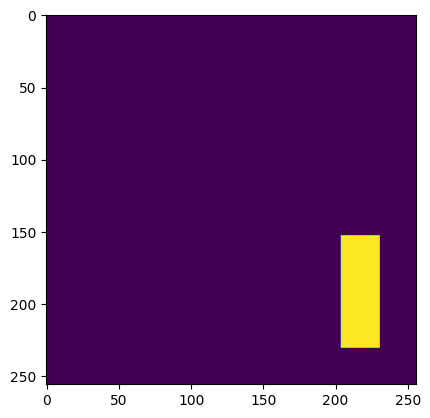

In [121]:
plt.imshow(img_body)

In [122]:
from data import read_original_data

In [123]:
import cv2
import copy

def get_image_sequence(instance, size=256, line_width=3):
    params = dict(size=256,
              line_width=3,
              initial_position=(instance[0][0],1-instance[0][1]),
              max_step=2e2,
              )
    
    env = DrawingEnv_Moc1(params)
    observation = env.init()
    
    images = [observation["image"]]
    mask = [observation["mask"]]
    actions = []
    for i in range(1, len(instance) - 1):
        if instance[i][5] == 0 and instance[i+1][5] == 0:
            if instance[i+1][3] == 0:
                position = (instance[i+1][0], 1-instance[i+1][1])
                
                observation, reward, done, info = env.step(position)
                images.append(observation["image"])
                mask.append(observation["mask"])
                action = (instance[i+1][0]-instance[i][0], instance[i+1][1]-instance[i][1])
                actions.append(action)
    
    # images = np.array(images).transpose(0,3,1,2).astype(np.uint8)
    images = np.array(images).astype(np.uint8)
    mask = np.array(mask).astype(np.uint8)
    observations = dict(image=images,mask=mask)
    actions = np.array(actions)
    rewards = np.zeros(len(actions))
    dones = np.zeros(len(actions))
    dones[-1] = 1
    return observations, actions, rewards, dones


In [124]:
import glob
data_dir = "DigiLeTs/data/preprocessed/complete"
filenames = glob.glob(os.path.join(data_dir, '*_preprocessed'))

In [125]:
import os
for idx in range(1):
    filename = filenames[idx]
    basename = os.path.basename(filename)
    participant = read_original_data(filename)
    if idx < 70:
        save_folder = "Drawing/train"
    else:
        save_folder = "Drawing/validation"
    for s, symbol in enumerate(participant["trajectories"]):
        if s > 9:
            # 数字以外は省略
            break
        for i, _instance in enumerate(symbol):
            
            instance = _instance[:participant["lengths"][s, i]]
            observations, actions, rewards, dones = get_image_sequence(instance, size=64, line_width=3)
            dataset = dict()
            dataset["image"] = observations["image"]
            dataset["mask"] = observations["mask"]
            dataset["action"] = actions
            dataset["reward"] = rewards
            dataset["done"] = dones
            
            break
        break

Reading from: DigiLeTs/data/preprocessed/complete/002-f-22-right_2019-06-05-12-21-29_preprocessed


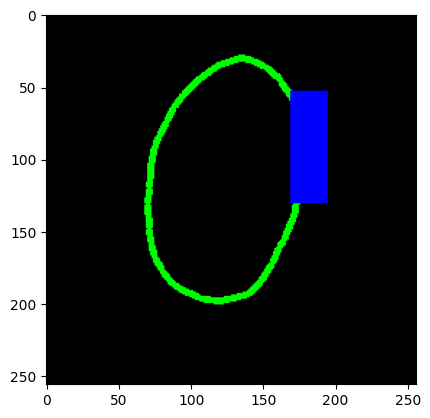

In [126]:
plt.imshow(dataset["image"][-1])

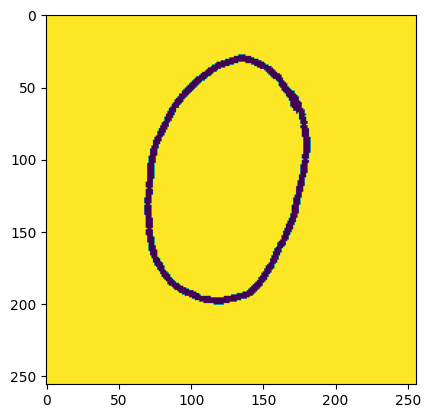

In [127]:
plt.imshow(dataset["mask"][-1,:,:,0]*255)

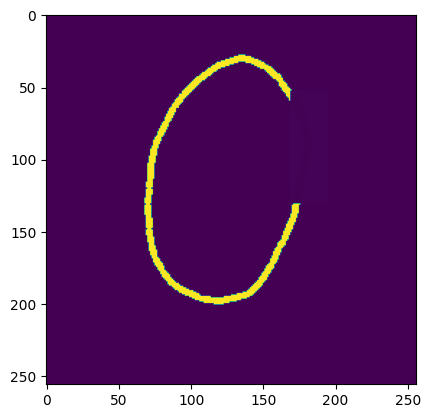

In [128]:
plt.imshow((dataset["mask"][-1,:,:,1]-dataset["mask"][-1,:,:,2])*255)